# Evaluation of the processed amplitude *using raw data*

This processor uses the averaged data of the amplitude analyser rather than the approximated hyoerbolic function.

# Setup

In [22]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
from colorama import Fore, Back, Style
import plotting_util
from reportlab.lib import pagesizes
from reportlab.lib.units import mm
from reportlab.lib import pagesizes
A6_LS = pagesizes.landscape(pagesizes.A6)
PAGE_SMALL = (160 * mm, 80 * mm)

import configuration as cfg


<Figure size 640x480 with 0 Axes>

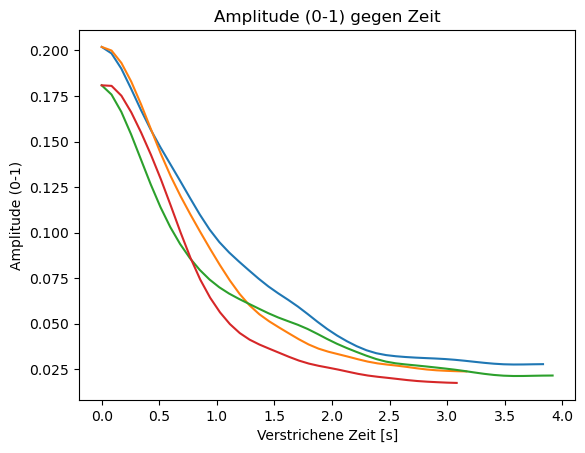

In [23]:
# Import serialized symmetrical list to file
def import_list_binary(filename: str):
    with open(filename + '.dat', 'rb') as fd:
        list = pickle.load(fd)
    return list


# left channel, part a and b
# right channel
avg_la = import_list_binary("data/hyperbolic_raw_data_la")
avg_lb = import_list_binary("data/hyperbolic_raw_data_lb")
avg_ra = import_list_binary("data/hyperbolic_raw_data_ra")
avg_rb = import_list_binary("data/hyperbolic_raw_data_rb")

plotting_util.plot_4_curves__vs_time(avg_la, avg_lb, avg_ra, avg_rb, cfg.averaging_resolution, "Amplitude (0-1)")

# Umrechnung von Amplitude auf Schallpegel (RMS) \[dB\]

Pseudocode Umrechnungsfunktionen:
```python
# a: Amplitude
amp_to_db(a: float) = 20 * log10(a)
amp_to_rms(a: float) = amp_to_db(sqrt((a * a) / 2))
```

In [24]:
def __amp_to_db(amplitude):
    """
    IMPORTANT: Returns a numpy array
    """
    return 20 * np.log10(amplitude)

def amp_to_rms(amplitude):
    amplitude = np.array(amplitude)
    return __amp_to_db(np.sqrt((np.multiply(amplitude, amplitude)) / 2))

## Three point RMS approach

~~**CAUTION:** This approach does only work with RMS values based on a hypberolic amplitude function. For discrete (raw) data, this approach returns arbitrary results.~~

*Correction:* It works nevertheless. Only difference: the velocity is only calculated using two datapoints. However, this may not be that bad, because the Gaussian filter averaged extreme deviations of the raw input data.
Currently, the points at $1/4$'ths and $2/4$'ths are used to calculate the average speed in the time frame with size ```time_increment```.    <span style="color:red">!!NOCHMAL CODE DURCHLESEN UND SCHAUEN, OB DAS RICHTIG IST, WAS ICH HIER BEHAUPTET HABE!!</span>

Because of the hyperbolic properties of the function, an arbitrary time / loudness frame can be chosen; regardless of the chosen frame, the calculated velocity is always constant.

<Figure size 640x480 with 0 Axes>

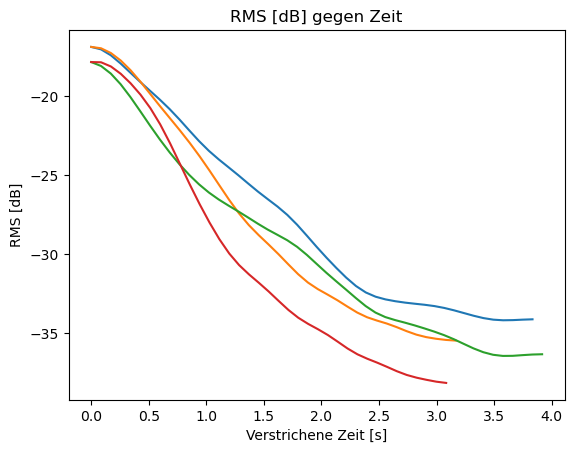

time increment: 1,25 s
-24,515759218906723	-32,70389720735821	-34,154789469001585	

time increment: 1,0 s
-23,820962898180454	-32,22295545651471	-35,362943738234456	

time increment: 1,25 s
-26,93789794456205	-33,70714806248613	-36,399118151454594	

time increment: 1,0 s
-26,853773699184806	-34,760794919417734	-38,077367122310015	



In [25]:
# plotting_util.plot_amplitude_data(
#     "Amplitude to RMS conversion", "Hyperbola (optimal_a)", cfg.averaging_resolution, data1=symm_array, axis2_name="RMS [dB]", data2=amp_to_rms(symm_array), graph_on_same_axis=True)

# rms_curve = amp_to_rms(symm_array)

rms_curve_la = amp_to_rms(avg_la)
rms_curve_lb = amp_to_rms(avg_lb)
rms_curve_ra = amp_to_rms(avg_ra)
rms_curve_rb = amp_to_rms(avg_rb)

plotting_util.plot_4_curves__vs_time(
    rms_curve_la, 
    rms_curve_lb, 
    rms_curve_ra, 
    rms_curve_rb, cfg.averaging_resolution, "RMS [dB]")

amt_print_vals = 3 # minimum of 3

def three_point_rms(rms_curve):
    num_samples = len(rms_curve)
    sample_increment = int(num_samples / amt_print_vals)
    time_increment = sample_increment / cfg.averaging_resolution
    rms_vals = [(rms_curve[sample_increment * (i + 1) - 1]) for i in range(amt_print_vals)]
    print(f"time increment: {str(time_increment).replace('.', ',')} s")
    for rms_value in rms_vals:
        print(str(rms_value).replace('.', ','), end='\t')
    print('\n')
    return (rms_vals, time_increment)

rms_vals_la, time_increment_la = three_point_rms(rms_curve_la)
rms_vals_lb, time_increment_lb = three_point_rms(rms_curve_lb)
rms_vals_ra, time_increment_ra = three_point_rms(rms_curve_ra)
rms_vals_rb, time_increment_rb = three_point_rms(rms_curve_rb)

# Pythagoras correction

<span style="color:red; font-size:30pt;">fehlt momentan noch</span>

# Weitere Korrektur des Codes (ausstehend):

Einzelne Messpunkte erst ab **Wendepunkt** verwenden

# Speed calculation

Using the data yielded by the amplitude to RMS converter, the speed of the passing vehicle is approximated.

Since the RMS curve is derived from a hyperbola, no extra precision is gained by calculating the speed at multiple points in time. However, due to the fact that the hyperbola is only an approximation of the actual amplitude curve, especially near $x = 0$, a value further from $0$ is picked (the hyperbola approaches a value of $\infty$ near $0$, which cannot be used in this formula).

See excel sheet "AmplitudeTest.xlsx" for empirical proof that speeds calculated with $x = 0$ including, differ from all other values.

In [26]:
r1 = 2.5 # radius_of_recording
L1 = 0 # maximum loudness

def radius2_from_3_known(radius1, Loudness1, Loudness2): # -> r2
    """
    Source of formula: http://www.sengpielaudio.com/Rechner-entfernung.htm
    """
    return radius1 * (10 ** (abs(Loudness1 - Loudness2) / 20))

def calc_speed_from_hypberbolic_input(rms_vals, time_increment):
    L2 = rms_vals[0]
    L3 = rms_vals[1]

    r2 = radius2_from_3_known(r1, L1, L2)
    r3 = radius2_from_3_known(r1, L1, L3)

    v2_3 = (r3 - r2) / time_increment
    return v2_3

v_la = calc_speed_from_hypberbolic_input(rms_vals_la, time_increment_la)
v_lb = calc_speed_from_hypberbolic_input(rms_vals_lb, time_increment_lb)
v_ra = calc_speed_from_hypberbolic_input(rms_vals_ra, time_increment_ra)
v_rb = calc_speed_from_hypberbolic_input(rms_vals_rb, time_increment_rb)

print(Fore.BLACK + Back.CYAN + f"Approximated speed LA: {v_la} [m/s] = {v_la * 3.6} [km/h]" + Style.RESET_ALL)
print(Fore.BLACK + Back.CYAN + f"Approximated speed LB: {v_lb} [m/s] = {v_lb * 3.6} [km/h]" + Style.RESET_ALL)
print(Fore.BLACK + Back.CYAN + f"Approximated speed RA: {v_ra} [m/s] = {v_ra * 3.6} [km/h]" + Style.RESET_ALL)
print(Fore.BLACK + Back.CYAN + f"Approximated speed RB: {v_rb} [m/s] = {v_rb * 3.6} [km/h]" + Style.RESET_ALL)
v_hyperbola_avg = (v_la + v_lb + v_ra + v_rb) / 4
print(Fore.BLACK + Back.YELLOW +
      f"AVERAGED SPEED: {v_hyperbola_avg} [m/s] = {v_hyperbola_avg * 3.6} [km/h]" + Style.RESET_ALL)


Approximated speed LA: 52.70549274780624 [m/s] = 189.73977389210248 [km/h]
Approximated speed LB: 63.30060829050292 [m/s] = 227.88218984581053 [km/h]
Approximated speed RA: 52.458758417321334 [m/s] = 188.85153030235682 [km/h]
Approximated speed RB: 81.73280915094412 [m/s] = 294.23811294339885 [km/h]
AVERAGED SPEED: 62.54941715164366 [m/s] = 225.17790174591718 [km/h]


Multiple speed calculations with averaging

<Figure size 640x480 with 0 Axes>

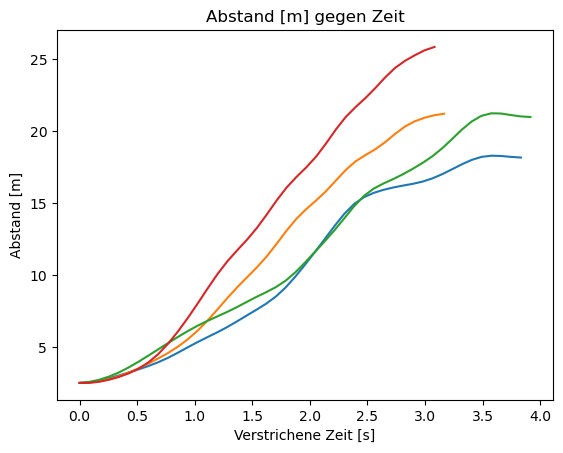

<Figure size 640x480 with 0 Axes>

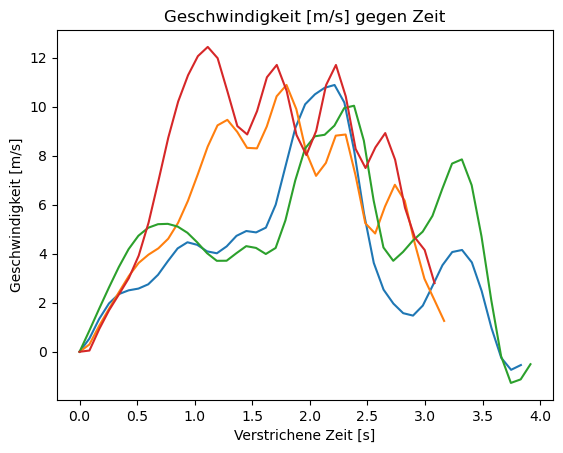

In [27]:
# Radius list calculation from RMS list

rms_curves_list = [rms_curve_la, rms_curve_lb, rms_curve_ra, rms_curve_rb]

# there is no more elegant way (unfortunately)
distance_list = [np.zeros(len(rms_curves_list[0])),
np.zeros(len(rms_curves_list[1])),
np.zeros(len(rms_curves_list[2])),
np.zeros(len(rms_curves_list[3]))]

velocity_list = [np.zeros(len(rms_curves_list[0])),
np.zeros(len(rms_curves_list[1])),
np.zeros(len(rms_curves_list[2])),
np.zeros(len(rms_curves_list[3]))] # no CLONE of empty distance_list!


r1 = 2.5  # radius_of_recording

for curve_list_counter in range(len(rms_curves_list)):
    L1 = rms_curves_list[curve_list_counter][0]  # maximum loudness (because the initial raw array is split at the maximum of the curve)

    for i in range(len(rms_curves_list[curve_list_counter])):
        L_i = rms_curves_list[curve_list_counter][i]
        r_i = radius2_from_3_known(r1, L1, L_i)
        distance_list[curve_list_counter][i] = r_i

        v_i = 0
        if i > 0:
            v_i = (r_i - distance_list[curve_list_counter][i - 1]) * cfg.averaging_resolution
        else:
            # first element in the RMS list
            v_i = (r_i - r1) * cfg.averaging_resolution
        
        velocity_list[curve_list_counter][i] = v_i

plotting_util.plot_4_curves__vs_time(distance_list[0], 
    distance_list[1],
    distance_list[2],
    distance_list[3], cfg.averaging_resolution, "Abstand [m]")

plotting_util.plot_4_curves__vs_time(velocity_list[0], 
    velocity_list[1],
    velocity_list[2],
    velocity_list[3], cfg.averaging_resolution, "Geschwindigkeit [m/s]")


In [28]:
r1 = 2.5  # radius_of_recording
def calc_speed_from_raw_input(rms_curve):
    L1 = rms_curve[0]  # maximum loudness

    # velocity calculation for all points in the RMS list
    r_prev = r1
    v_list = np.empty(len(rms_curve))
    for i in range(len(rms_curve)):
        L_x = rms_curve[i]
        r_x = radius2_from_3_known(r1, L1, L_x)
        print(r_x)
        # naming explanation: v_(previous radius)_(radius x)
        # v = s/t  ;  t = 1/res
        v_prev_x = (r_x - r_prev) * cfg.averaging_resolution
        # print(v_prev_x)
        v_list = np.append(v_list, v_prev_x)
        r_prev = r_x
    
    v_min = np.min(v_list)
    v_avg = np.mean(v_list)
    v_median = np.median(v_list)
    v_max = np.max(v_list)

    return (v_min, v_avg, v_median, v_max)


v_raw_min_avg = 0
v_raw_avg_avg = 0
v_raw_median_avg = 0
v_raw_max_avg = 0
rms_curves_list = [rms_curve_la, rms_curve_lb, rms_curve_ra, rms_curve_rb]
names_list = ["LA", "LB", "RA", "RB"]
print("Values in [m/s] \u2259 [km/h]")
print(" min | avg | median | max")
for i in range(4):
    v_min, v_avg, v_median, v_max = calc_speed_from_raw_input(rms_curves_list[i])
    print(Fore.BLACK + Back.CYAN +
          f"Approximated speed {names_list[i]}: {v_min:.1f} \u2259 {v_min*3.6:.1f} \t| \
    {v_avg:.1f} \u2259 {v_avg*3.6:.1f} \t| \
    {v_median:.1f} \u2259 {v_median*3.6:.1f} \t| \
    {v_max:.1f} \u2259 {v_max*3.6:.1f} \t" + Style.RESET_ALL)

    v_raw_min_avg += v_min
    v_raw_avg_avg += v_avg
    v_raw_median_avg += v_median
    v_raw_max_avg += v_max

v_raw_min_avg /= 4
v_raw_avg_avg /= 4
v_raw_median_avg /= 4
v_raw_max_avg /= 4




print(Fore.BLACK + Back.CYAN +
      f"""Mininmum: {v_raw_min_avg} [m/s] = {v_raw_min_avg * 3.6} [km/h]
      Average: {v_raw_avg_avg} [m/s] = {v_raw_avg_avg * 3.6} [km/h]
      Median: {v_raw_median_avg} [m/s] = {v_raw_median_avg * 3.6} [km/h]
      Maximum: {v_raw_max_avg} [m/s] = {v_raw_max_avg * 3.6} [km/h]""" + Style.RESET_ALL)

# plotting_util.plot_4_curves__vs_time(r1_list, r1_list, r1_list, r1_list, cfg.averaging_resolution, "Abstand [m]")


Values in [m/s] ≙ [km/h]
 min | avg | median | max
2.5
2.54483597817122
2.6565250241323115
2.820952515954518
3.016986479517098
3.2258506317467233
3.440662807531583
3.6699918475371165
3.931745936101665
4.239815204159307
4.5913278196136575
4.96367990144297
5.3272779909252055
5.668681599930184
6.003605971411754
6.362010336838115
6.75614280711209
7.166781267507957
7.572688001957701
7.9948278026631705
8.495168634641047
9.12625032776789
9.887030352252742
10.728557424283764
11.604051802858844
12.50191704762442
13.409136181353967
14.256634073270842
14.940175283768921
15.410583405679436
15.712737169087937
15.923830229494197
16.087569699140097
16.21877575337754
16.341741593395604
16.498798194294395
16.723313702798293
17.017556151374606
17.35673684326388
17.702893559974267
18.00674108700157
18.21349374070937
18.294380979150294
18.27362496821221
18.21225378061302
18.16711404727846
Approximated speed LA: -0.7 ≙ -2.7 	|     3.0 ≙ 10.8 	|     2.5 ≙ 9.2 	|     10.9 ≙ 39.2 	
2.5
2.5248918800687488
2.61